# StateOrdering.ipynb
## Ordering and visualizing state associations for hidden Markov models

Here I will demonstrate two ways to order states of a hidden Markov model, with a key assumption being that cells/units have no defined topography/topology. That is, in the hippocampus, (place) cells are recruited at random, and neighboring place cells are not guaranteed to have adjacent or even nearby place fields. This lack of cellular topology motivates us to use the Hellinger distance, described later, whereas if the cellular topology _is_ important, then we can consider something like the Wasserstein (earth mover's) distance instead.

First, it should be obvious that state labels from a hidden Markov model are arbitrary, and the model itself does not impose any ordering on the set of states. However, in practice we may very well be interested to know that states $i$ and $j$ are "closer" to each other than states $i$ and $k$, for example.

The first ordering approach I will consider, is based simply on a greedy re-ordering of the states based on their transition probabilities. We start with any state, say $S_0=i$, and then greedily select the next state, which has highest probability of occurence after $i$, and so on. This ordering is not necessarily optimal in any sense, but it should be close to optimal in many ways that make sense. However, two limitations to such an approach include the (i) linear ordering, and the (ii) lack of distance information. For example, if we have a T-maze, then what ordering should we choose? At some point, the greedy algorithm might be forced to group two states together that are nowhere close to each other. Second, we have no information to know how much closer two adjacent states are to each other than to a neighbor one or two spaces removed.

Both of the above limitations can be mitigated to some extent by using multidimensional scaling (MDS), Isomap, or some similar techniques. Here I consider MDS, where we attempt to find an optimal embedding of the states in a 2-dimensional or a 1-dimensional space, depending on our belief about the underlying environment. 

In particular, I use the Hellinger distance to compute point-wise distances between different state-unit pairs. For example, for any pair of states $S_A$ and $S_B$ and an associated unit $u$, we have Poisson firing rates $u_A$ and $u_B$, so that we compute the squared Hellinger distance between these Poisson distributions as
$$
H^2\bigl(S_A(u),S_B(u)\bigr) = 1-\exp\biggl(-\frac{1}{2}\bigl(\sqrt{u_A} - \sqrt{u_B}\bigr)^2\biggr).
$$
Then we simply consider the pairwise distance between the two states as the average Hellinger distance over all the units:
$$
D(S_A,S_B) = \dfrac{1}{|U|}\sum_{u \in U} H\bigl(S_A(u), S_B(u) \bigr).
$$

Using $D$ as our distance function in MDS and projecting the data onto a 1-dimensional subspace then reveals both an ordering for the states, as well as approximate distances between those states, allowing us to make observations such as "state $i$ is much more similar to state $j$ than it is to state $k$," and so on. Of course, if we project it onto a 2-dimensional subspace, then we could potentially learn even more about the state associations, in that we can learn about state adjecency and proximity even when the underlying states cannot be described by a simple linear ordering.

**Idea:** Perhaps I should simulate this with a T or 3-arm maze (or even an $N$-arm maze) and show how the state associations can reveal the nonexistence of a suitable linear ordering.

**Remark:** The above approaches have been designed with the assumption that we need to do this in a completely unsupervised manner. Of course, if we actually have some position data for the animals, we can create a heatmap of the decoded states, allowing us to assign the states to the modes of their spatial distributions. This idea is not demonstrated here.


In [133]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

sys.path.insert(0, 'helpers')

from efunctions import * # load my helper function(s) to save pdf figures, etc.
from hc3 import load_data, get_sessions
import klabtools as klab
import seqtools as sq

%matplotlib inline
#mpld3.enable_notebook()

sns.set(rc={'figure.figsize': (12, 4),'lines.linewidth': 1, 'font.size': 18, 'axes.labelsize': 16,
            'legend.fontsize': 12, 'ytick.labelsize': 12, 'xtick.labelsize': 12 })
sns.set_style("white")

In [134]:
from hmmlearn import hmm # see https://github.com/ckemere/hmmlearn
import importlib

importlib.reload(sq) # reload module here only while prototyping...
importlib.reload(klab) # reload module here only while prototyping...

<module 'klabtools' from 'helpers\\klabtools.py'>

In [135]:
import sys 
import time

from IPython.display import display, clear_output
#for i in range(10):
#    time.sleep(0.25)
#    clear_output(wait=True)
#    print(i)
#    sys.stdout.flush()

## Load data

In [136]:
datadirs = ['/home/etienne/Dropbox/neoReader/Data',
            'C:/etienne/Dropbox/neoReader/Data',
            '/Users/etienne/Dropbox/neoReader/Data']

fileroot = next( (dir for dir in datadirs if os.path.isdir(dir)), None)

Loading data for session in directory 'C:\etienne\Dropbox\neoReader\Data/gor01-6-7/2006-6-7_16-40-19'...
Number of electrode (.clu) files found: 12
Spike times (in sample numbers) for a total of 91 units were read successfully...
Loading EEG data from file 'C:\etienne\Dropbox\neoReader\Data/gor01-6-7/2006-6-7_16-40-19/2006-6-7_16-40-19.eeg'
Number of electrode (.clu) files found: 12, with a total of 96 channels
Successfully read 3239936 samples for each of the 3 channel(s).
reading position data from 'C:\etienne\Dropbox\neoReader\Data/gor01-6-7/2006-6-7_16-40-19/2006-6-7_16-40-19.whl'
The animal (gor01) ran an average of 2.89 units/s
The animal ran faster than th = 8.0 units/s for a total of 237.7 seconds (out of a total of 2587.8 seconds).


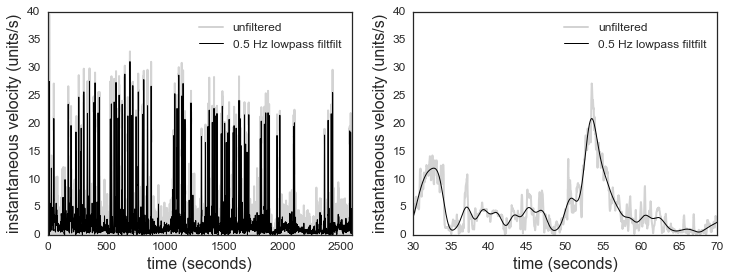

In [137]:
animal = 'gor01'; month,day = (6,7); session = '11-26-53' # WARNING! POSITION DATA INCOMPLETE!
animal = 'gor01'; month,day = (6,7); session = '16-40-19' # 91 units

#animal = 'gor01'; month,day = (6,12); session = '15-55-31' # 55 units
#animal = 'gor01'; month,day = (6,12); session = '16-53-46' # 55 units

#animal = 'gor01'; month,day = (6,13); session = '14-42-6' # 58 units
#animal = 'gor01'; month,day = (6,13); session = '15-22-3' # 58 units

#animal = 'vvp01'; month,day = (4,9); session = '16-40-54' # ?? units
#animal = 'vvp01'; month,day = (4,9); session = '17-29-30' # ?? units

#animal = 'vvp01'; month,day = (4,10); session = '12-25-50' # lin1; ?? units
#animal = 'vvp01'; month,day = (4,10); session = '12-58-3'  # lin2; ?? units
#animal = 'vvp01'; month,day = (4,10); session = '19-11-57' # lin2; ?? units
#animal = 'vvp01'; month,day = (4,10); session = '21-2-40'  # lin1; ?? units

#animal = 'vvp01'; month,day = (4,18); session = '13-06-01' # lin1; ?? units
#animal = 'vvp01'; month,day = (4,18); session = '13-28-57' # lin2; ?? units
#animal = 'vvp01'; month,day = (4,18); session = '15-23-32' # lin1; ?? units
#animal = 'vvp01'; month,day = (4,18); session = '15-38-02' # lin2; ?? units

spikes = load_data(fileroot=fileroot, datatype='spikes',animal=animal, session=session, month=month, day=day, fs=32552, verbose=True)
eeg = load_data(fileroot=fileroot, datatype='eeg', animal=animal, session=session, month=month, day=day,channels=[0,1,2], fs=1252, starttime=0, verbose=True)
posdf = load_data(fileroot=fileroot, datatype='pos',animal=animal, session=session, month=month, day=day, verbose=True)
speed = klab.get_smooth_speed(posdf,fs=60,th=8,cutoff=0.5,showfig=True,verbose=True)

In [138]:
## bin ALL spikes
ds = 0.125 # bin spikes into 125 ms bins (theta-cycle inspired)
binned_spikes = klab.bin_spikes(spikes.data, ds=ds, fs=spikes.samprate, verbose=True)

## identify boundaries for running (active) epochs and then bin those observations into separate sequences:
runbdries = klab.get_boundaries_from_bins(eeg.samprate,bins=speed.active_bins,bins_fs=60)
binned_spikes_bvr = klab.bin_spikes(spikes.data, fs=spikes.samprate, boundaries=runbdries, boundaries_fs=eeg.samprate, ds=ds)

## stack data for hmmlearn:
seq_stk_bvr = sq.data_stack(binned_spikes_bvr, verbose=True)
seq_stk_all = sq.data_stack(binned_spikes, verbose=True)

## split data into train, test, and validation sets:
tr_b,vl_b,ts_b = sq.data_split(seq_stk_bvr, tr=60, vl=10, ts=30, randomseed = 0, verbose=True)

## train HMM on active behavioral data; training set (with a fixed, arbitrary number of states for now):
myhmm = sq.hmm_train(tr_b, num_states=35, n_iter=50, verbose=False)

binning data into 20703 x 125.0 ms temporal bins...
90 sequences being stacked...
Total sequence length: 1938 bins, each of width 0.125 seconds
Successfully stacked 90 sequences for a total of 242.25 seconds of data.
Only one sequence in data; so data is already in stacked format...
Splitting 90 sequences into train, validation, and test sets...
54 sequences being stacked...
Total sequence length: 1163 bins, each of width 0.125 seconds
Successfully stacked 54 sequences for a total of 145.38 seconds of data.
9 sequences being stacked...
Total sequence length: 174 bins, each of width 0.125 seconds
Successfully stacked 9 sequences for a total of 21.75 seconds of data.
27 sequences being stacked...
Total sequence length: 601 bins, each of width 0.125 seconds
Successfully stacked 27 sequences for a total of 75.12 seconds of data.
Stacked data split into train (60.0 %), validation (10.0 %) and test (30.0 %) sequences.


## Basic visualization of hmm state evolutions

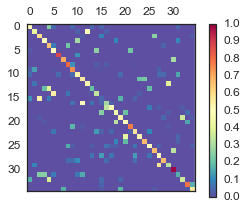

In [139]:
myhmm.transmat_.sum(axis=1) # confirm orientation of transition prob matrix
A = myhmm.transmat_.copy()
fig, ax = plt.subplots(figsize=(3.5, 3))
im = ax.matshow(A, interpolation='none', cmap='Spectral_r')
# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cax)

<Container object of 3 artists>

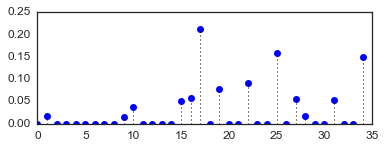

In [140]:
m = myhmm.n_components
Pi = myhmm.startprob_.copy()
Pi = np.reshape(Pi,(1,m))
fig, ax = plt.subplots(figsize=(6, 2))
ax.stem(np.transpose(Pi),':k')

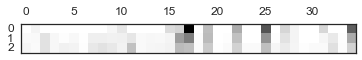

In [141]:
fig, ax = plt.subplots(figsize=(6, 2))
ax.matshow(Pi)
PiA = np.dot(Pi,A)
ax.matshow(np.vstack([Pi,PiA,np.dot(PiA,A)]))

In [142]:
def advance_states(St,A,n):
    count = 1
    St = np.dot(St,A)
    while count <= n:
        yield St
        count += 1
        St = np.dot(St,A)

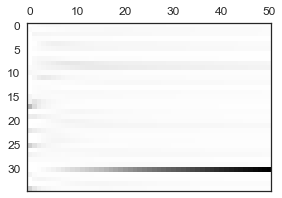

In [143]:
numsteps = 50
prior_evo = np.zeros((numsteps+1,m))
prior_evo[0,:] = Pi
for ii, S in enumerate(advance_states(Pi, A, numsteps)):
    prior_evo[ii+1,:] = S
    
fig, ax = plt.subplots(figsize=(10, 3))
ax.matshow(np.transpose(prior_evo))

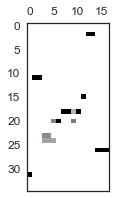

In [144]:
seq_id = 0
tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(ts_b.sequence_lengths).tolist());
obs = ts_b.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
ll, pp = myhmm.score_samples(obs)
fig, ax = plt.subplots(figsize=(10, 3))
ax.matshow(np.transpose(pp))

In [145]:
def advance_states_one(pp, A):
    return np.dot(pp, A)

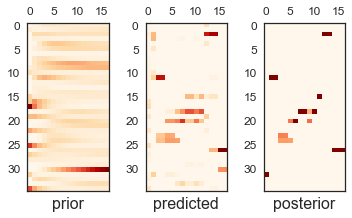

In [146]:
ppp = advance_states_one(np.vstack([Pi,pp[:pp.shape[0]-1,:]]), A)

numsteps = pp.shape[0]-1
prior_evo = np.zeros((numsteps+1,m))
prior_evo[0,:] = Pi
for ii, S in enumerate(advance_states(Pi, A, numsteps)):
    prior_evo[ii+1,:] = S
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 3))
ax1.matshow(np.transpose(prior_evo),cmap='OrRd'); ax1.set_xlabel('prior')
ax2.matshow(np.transpose(ppp),cmap='OrRd'); ax2.set_xlabel('predicted')
ax3.matshow(np.transpose(pp),cmap='OrRd'); ax3.set_xlabel('posterior')

In [147]:
# sort model states:
new_order = [0]
rem_states = np.arange(1,m).tolist()
cs = 0

for ii in np.arange(0,m-1):
    nstilde = np.argmax(A[cs,rem_states])
    ns = rem_states[nstilde]
    rem_states.remove(ns)
    cs = ns
    new_order.append(cs)
    
Anew = A[:, new_order][new_order]

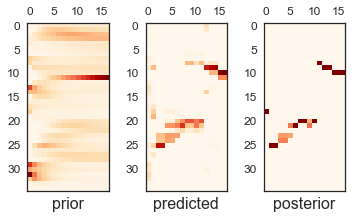

In [148]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 3))
ax1.matshow(np.transpose(prior_evo)[new_order,:],cmap='OrRd'); ax1.set_xlabel('prior')
ax2.matshow(np.transpose(ppp)[new_order,:],cmap='OrRd'); ax2.set_xlabel('predicted')
ax3.matshow(np.transpose(pp)[new_order,:],cmap='OrRd'); ax3.set_xlabel('posterior')

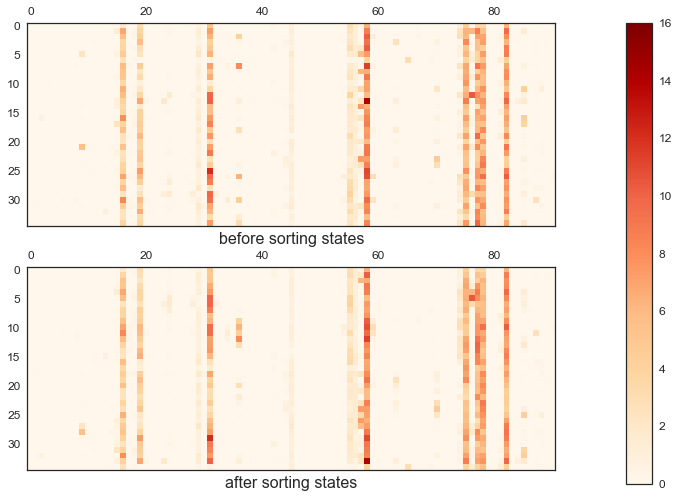

In [149]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
im = ax1.matshow(myhmm.means_, cmap='OrRd', vmin=0, vmax=16); ax1.set_xlabel('before sorting states')
im = ax2.matshow(myhmm.means_[new_order,:], cmap='OrRd', vmin=0, vmax=16); ax2.set_xlabel('after sorting states')

# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cax)

binning data into 155269 x 16.7 ms temporal bins...
23 out of 91 cells passed the criteria to be place cells...


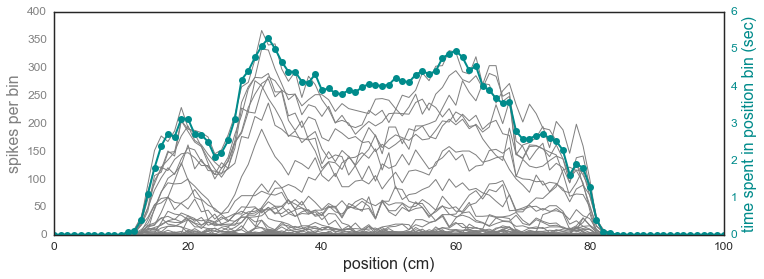

In [150]:
ds = 1/60 # bin spikes into 1/60 ms bins, corresponding to video sampling period
binned_spikes = klab.bin_spikes(spikes.data, ds=ds, fs=spikes.samprate, verbose=True)
runidx = speed.active_bins
lin_pos = (posdf.x1.values + posdf.x2.values)/2
pfs, pfbincenters, pindex = klab.estimate_place_fields(lin_pos[runidx],binned_spikes.data[runidx],fs=60, 
    x0=0,xl=100, max_meanfiringrate = 5,min_maxfiringrate=3,num_pos_bins=100,sigma=1, verbose=True,showfig=True)

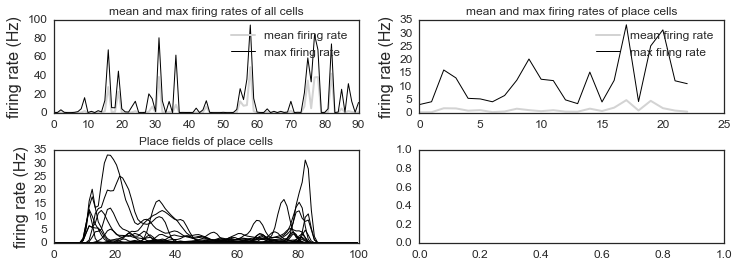

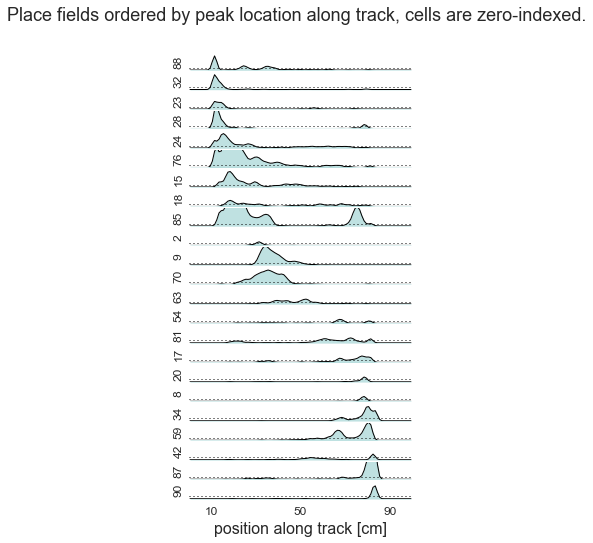

In [151]:
klab.show_place_fields(pfs,pfbincenters,pindex,min_maxfiringrate=2)

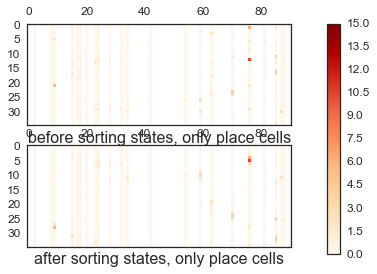

In [152]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4))
MM = myhmm.means_.copy()
for cell in np.arange(0,MM.shape[1]):
    if cell not in pindex:
        MM[:,cell] = np.nan
im = ax1.matshow(MM, cmap='OrRd', vmin=0, vmax=15); ax1.set_xlabel('before sorting states, only place cells')
im = ax2.matshow(MM[new_order,:], cmap='OrRd', vmin=0, vmax=15); ax2.set_xlabel('after sorting states, only place cells')

# Make an axis for the colorbar on the right side
cax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
fig.colorbar(im, cax=cax)

In [153]:
from random import shuffle

lp, pth = myhmm.decode(obs,algorithm='map')
trj_shfl_idx = np.arange(0,len(pth))
shuffle(trj_shfl_idx)
obs_shfl = np.array([obs[i] for i in trj_shfl_idx])
lp_shfl, pp_shfl = myhmm.score_samples(obs_shfl)
ppp_shfl = advance_states_one(np.vstack([Pi,pp_shfl[:pp_shfl.shape[0]-1,:]]), A)


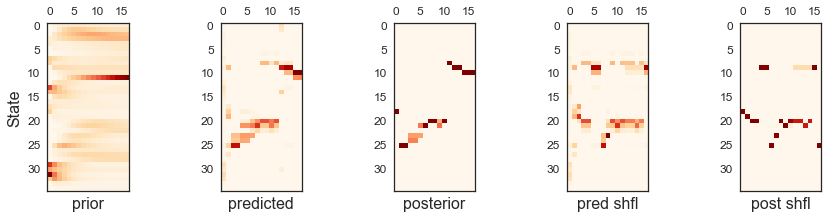

In [154]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(15, 3))
ax1.matshow(np.transpose(prior_evo)[new_order,:],cmap='OrRd'); ax1.set_xlabel('prior'); ax1.set_ylabel('State')
ax2.matshow(np.transpose(ppp)[new_order,:],cmap='OrRd'); ax2.set_xlabel('predicted')
ax3.matshow(np.transpose(pp)[new_order,:],cmap='OrRd'); ax3.set_xlabel('posterior')
ax4.matshow(np.transpose(ppp_shfl)[new_order,:],cmap='OrRd'); ax4.set_xlabel('pred shfl')
ax5.matshow(np.transpose(pp_shfl)[new_order,:],cmap='OrRd'); ax5.set_xlabel('post shfl')

**Remark:** What if our pmfs contain any zeros? Problem! 
    
One way to think about your problem is that you don't really have confidence in the PMF you have calculated from the histogram. You might need a slight prior in your model. Since if you were confident in the PMF, then the KL divergence should be infinity since you got values in one PMF that are impossible in the other PMF. If, on the other hand you had a slight, uninformative prior then there is always some small probability of seeing a certain outcome. One way of introducing this would be to add a vector of ones times some scalar to the histogram. The theoretical prior distribution you would be using is the **dirichlet distribution**, which is the conjugate prior of the **categorical distribution**. But for practical purposes you can do something like
```python
    pmf_unnorm = scipy.histogram(samples, bins=bins, density=True)[0] +  w * scipy.ones(len(bins)-1)
    pmf = pmf_unnor / sum(pmf_unnorm)
```
where ```w``` is some positive weight, depending on how strong a prior you want to have.

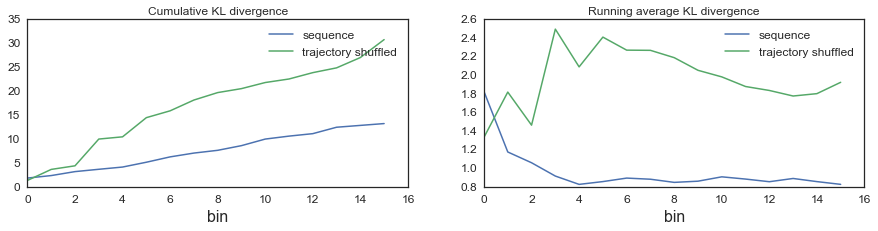

In [155]:
from scipy.stats import entropy as KLD

KLlist = []
KLlist_shfl = []

for ii in np.arange(1,len(pth)):
    KLlist.append(KLD(pp[ii,:],ppp[ii,:]))
    KLlist_shfl.append(KLD(pp_shfl[ii,:],ppp_shfl[ii,:]))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 3))

ax1.plot(np.cumsum(KLlist), label='sequence', lw=1.5)
ax1.plot(np.cumsum(KLlist_shfl), label='trajectory shuffled', lw=1.5)
ax1.legend()
ax1.set_xlabel('bin')
ax1.set_title('Cumulative KL divergence')

seqscore = np.cumsum(KLlist) / np.arange(1,len(pth))
seqscore_shfl = np.cumsum(KLlist_shfl) / np.arange(1,len(pth))

ax2.plot(seqscore, label='sequence', lw=1.5)
ax2.plot(seqscore_shfl, label='trajectory shuffled', lw=1.5)
ax2.legend()
ax2.set_xlabel('bin')
ax2.set_title('Running average KL divergence')

**First look at shuffle distribution for single sequence:**

In [156]:
def KL(distr_matU, distr_matV):
    from scipy.stats import entropy as KLD
    num_bins = distr_matU.shape[0]

    KLarray = np.zeros(num_bins)
    
    for ii in np.arange(1,num_bins):
        KLarray[ii-1] = KLD(distr_matU[ii,:],distr_matV[ii,:])
        
    return KLarray.mean()

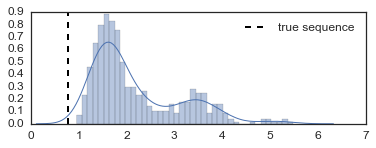

In [157]:
from random import shuffle

###########################################################3
stacked_data = ts_b
seq_id = 0
n_shuffles = 500
###########################################################3

tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());
obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
ll, pp = myhmm.score_samples(obs)
num_bins = obs.shape[0] 
ppp = advance_states_one(np.vstack([Pi,pp[:num_bins-1,:]]), A)
trj_shfl_idx = np.arange(0, num_bins); 
KL_true = KL(pp,ppp)

KL_shuffles = np.zeros(n_shuffles)
for nn in np.arange(0,n_shuffles):
    shuffle(trj_shfl_idx)
    obs_shfl = np.array([obs[i] for i in trj_shfl_idx])
    ll_shfl, pp_shfl = myhmm.score_samples(obs_shfl)
    ppp_shfl = advance_states_one(np.vstack([Pi,pp_shfl[:num_bins-1,:]]), A)
    KL_shuffles[nn] = KL(pp_shfl,ppp_shfl)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 2))

sns.distplot(KL_shuffles, ax=ax1, bins=40)
ax1.axvline(x=KL_true, ymin=0, ymax=1, linewidth=2, color = 'k', linestyle='dashed', label='true sequence')
ax1.legend()

**Now look at entire data set, with shuffles for each sequence:**


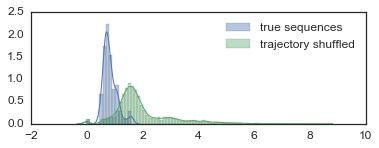

In [168]:
from random import shuffle

###########################################################3
stacked_data = ts_b
n_shuffles = 250 # shuffles PER sequence in data set
###########################################################3

num_sequences = len(stacked_data.sequence_lengths)
tmpseqbdries = [0]; tmpseqbdries.extend(np.cumsum(stacked_data.sequence_lengths).tolist());

KL_true = np.zeros(num_sequences)
KL_shuffles = np.zeros((num_sequences,n_shuffles))

for seq_id in np.arange(0,num_sequences):

    obs = stacked_data.data[tmpseqbdries[seq_id]:tmpseqbdries[seq_id+1],:]
    ll, pp = myhmm.score_samples(obs)
    num_bins = obs.shape[0] 
    ppp = advance_states_one(np.vstack([Pi,pp[:num_bins-1,:]]), A)
    trj_shfl_idx = np.arange(0, num_bins); 
    KL_true[seq_id] = KL(pp,ppp)

    for nn in np.arange(0,n_shuffles):
        shuffle(trj_shfl_idx)
        obs_shfl = np.array([obs[i] for i in trj_shfl_idx])
        ll_shfl, pp_shfl = myhmm.score_samples(obs_shfl)
        ppp_shfl = advance_states_one(np.vstack([Pi,pp_shfl[:num_bins-1,:]]), A)
        KL_shuffles[seq_id,nn] = KL(pp_shfl,ppp_shfl)

fig, ax1 = plt.subplots(1, 1, figsize=(6, 2))

sns.distplot(KL_true, ax=ax1, label='true sequences')
sns.distplot(KL_shuffles.flatten(), bins=80, ax=ax1, label='trajectory shuffled')
#ax1.axvline(x=KL_true, ymin=0, ymax=1, linewidth=2, color = 'k', linestyle='dashed', label='true sequence')
#ax1.set_xlim([0,5])
ax1.legend()

## Aside
What is a good distance to use for getting a linear state sequence using MDS?

In particular, If I have discrete distributions
$$
p_1 = [0, 1, 0, 0, 0, 0]\\
p_2 = [0, 0, 0, 1, 0, 0]\\
p_3 = [0, 0, 0, 0, 0, 1]
$$
then I hope to find that $d(p_1,p_2) < d(p_1,p_3)$. Euclidian distance won't give that to me, and neither will something based on KL divergence, for example.

This may be a red herring, because the above example already assumes a linear ordering of the states, which is what I hope to discover. Also, say we have four (or more) pairwise equidistant states, then clearly it is impossible to visualize such a configuration in 2D.

**Update:** I was NOT thinking clearly when I wrote this aside. Indeed, we don't care about any cell/unit ordering. That is completely arbitrary. We can still use MDS or something similar to find a (close to) optimal ordering in a lower dimension, which even gives us some additional spatial information, but perhaps Euclidean distances are not appropriate, and a Hellinger distance would be better.

The squared Hellinger distance between two Poisson distributions with rate parameters $\alpha$ and $\beta$, so that $ P\,\sim \,\rm{Poisson}(\alpha)$ and $Q\,\sim\,\rm{Poisson}(\beta)$, is:
$$
H^2(P,Q) = 1-e^{-\frac{1}{2}(\sqrt{\alpha} - \sqrt{\beta})^2}.
$$  
Perhaps we can sum these distances over units, to get a pair-wise distance between states. (Normalization is not necessary, but is trivial if we want to compare different experiments).

At any rate, the Wasserstein or earth-mover's metric (https://en.wikipedia.org/wiki/Wasserstein_metric) does what I was looking for originally. That is, intuitively, the metric is defined as the minimum cost to transform one distribution into another: amount times distance. https://github.com/garydoranjr/pyemd

## Remember to plot state vs position, and ...

In [ ]:
def gauss_maker(A,a,x0):
    def f(x):
        return A*np.exp(-a*(x-x0)**2)
    return f

x = np.linspace(0,1)
g = gauss_maker(99.0,1.0,0.5)
plt.plot(x,g(x))

## Discussion and further considerations

The KL-based sequence score actually works remarkably well when looking at individual examples. On a population level, the results seem good, but not great, but this might be due to several "bad" sequences in the data. For example, some sequences are quite short (4 bins) where only one or two states are visited. Consequently, reshuffling the data using a trajectory shuffle does nothing to the sequence, and we get false positives for shuffled data that was classified as a true sequence.

**Remaining important characterizations:**
I should consider other distributions here, such as the RUN > 8 vs NORUN < 4 distributions, and I should also split up data into lin1a, lin1b (splitting when the track was shortened) and lin2a and lin2b data. Each of those subsets of data can also be split into RUN > 8 and NORUN < 4 subsets to try and observe finer discrimination.

Of course, I should also characterize this score with the numerous other shuffling strategies that are commonly employed, including the unit-ID shuffle, etc.

**KL is not symmetric:**
There can be some debate about whether it is more appropriate to use $D_\text{KL}(U||V)$ or $D_\text{KL}(V||U)$. As of now, I am leaning in favor of $D_\text{KL}(U||V)$, where $V$ is the expected model evolution, and $U$ is the actual observed behavior. I have tested both, and both consistently gives a lower score (more similarity) to true sequences than to shuffled sequences.

**About the place fields:**
The place fields here also don't look that great, but that is partly due to the fact that I don't consider directionality here, and also I don't split the experiment into the parts before and after the track was shortened. However, we don't actually _use_ any of the place field information in this entire analysis, so that it should not be of any real concern. We can of course estimate them better, if we really have to...

**Notation:**
Importantly, I should re-write the introduction to be more friendly, making my notation consistent and final, and I should demonstrate why this approach makes both intuitive and mathematical sense. I do like the notation used above, where $p(S_t|\mathbf{y}_{1:T})$ is the _posterior_ state distribution at time $t$ having observed the sequence $\mathbf{y}_{1:T}$, and I also like the notation for distinguishing between distributions $p(\cdot)$ and probabilities $P(\cdot)$ although if I draw attention to this distinction, I have to be very careful to follow such a convention consistently.

**What's next? How can we derive an effective final score?**
Finally, what then, is my final sequence score? I still have both sequential and contextual components, but I need to think more carefully about the best way to make the KL-score into the sequential component. For one thing, a score is typically better if it is larger, but so far we have opposite desired directions for the contextual and sequential components (larger ctx is good, smaller KL is good). Another issue is interpretability, both local and global. Local interpretability might answer how likely we are to observe a KL score that small or smaller, based on a shuffle distribution of the sequence under consideration, but it would be more appealing to not have to compute shuffle distributions first, and also to have global interpretability, which would allow us to say "this sequence is more consistent with the underlying model than that sequence".